In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
!pip install gdown

In [5]:
import gdown

In [6]:
!gdown --id 1E8N8C4CMrSedmuthVhJEqJIub0jRqGVg

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1E8N8C4CMrSedmuthVhJEqJIub0jRqGVg
To: /kaggle/working/BBC_text.zip
100%|███████████████████████████████████████| 1.93M/1.93M [00:00<00:00, 125MB/s]


In [7]:
import zipfile

zip_path = '/kaggle/working/BBC_text.zip'
extract_path = '/kaggle/working/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [8]:
import numpy as np
import pandas as pd
import os
import re
import string
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import random
import spacy
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from keras.utils import to_categorical
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
# from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Bidirectional ,GRU ,SpatialDropout1D ,Attention
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


2024-06-17 19:51:40.882605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 19:51:40.882728: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 19:51:41.035712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Import Dataset**

In [9]:
data = pd.read_csv('/kaggle/working/bbc_data.csv')
data

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    2225 non-null   object
 1   labels  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [11]:
# Check missing values
data.isna().sum().to_frame(name = 'Num. Nan')

,Num. Nan
data,0
labels,0


**We don't have any Missing value**

In [12]:
# Calculate the number of unique values and their occurrences in the 'rating' column
unique_values_count = data['labels'].nunique()
value_counts = data['labels'].value_counts()

# Display the number of unique values and their occurrences
print(f"Number of unique values in the 'labels' column: {unique_values_count}")
print("\nUnique values and their occurrences:")
value_counts

Number of unique values in the 'labels' column: 5

Unique values and their occurrences:


labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

**We check the labels so that we don't have an imbalance problem**

In [13]:
emotion_counts = data['labels'].value_counts()

fig = px.pie(emotion_counts, values=emotion_counts.values, names=emotion_counts.index,
             title='Labels Distribution', hole=.3)
fig.update_traces(textinfo='percent+label', pull=[0.1]*len(emotion_counts))
fig.show()

In [14]:
data

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


In [15]:
data = data.drop_duplicates()
data.shape

(2126, 2)

In [16]:
News_list = data['data'].tolist()

# Randomly select three News articles
random_three_News = random.sample(News_list, 3)

# Extract 50 words from the randomly selected three News
words = []
for News in random_three_News:
    words.extend(News.split()[:50])

# Print the randomly selected 50 words
print("\nSelected 50 words from the random three News articles:")
print(' '.join(words))


Selected 50 words from the random three News articles:
BNP leader Nick Griffin arrested The leader of the British National Party has been arrested as part of a police inquiry following the screening of a BBC documentary. A party spokesman said Nick Griffin was arrested on Tuesday morning on suspicion of incitement to commit racial hatred. West Yorkshire police Tsunami slows Sri Lankas growth Sri Lankas president has launched a reconstruction drive worth $3.5bn (xc2xa31.8bn) by appealing for peace and national unity. President Kumaratunga said it was now important to find a peaceful solution to years of internal conflict. Meanwhile, the International Monetary Fund (IMF) said damage from the ODriscoll saves Irish blushes Two moments of magic from Brian ODriscoll guided Ireland to a workmanlike victory against Italy. A pair of classic outside breaks from the Ireland captain set up tries for Geordan Murphy and Peter Stringer. Italy led 9-8 early in the second half but Stringers try gave


**We created a loop in order to view the various texts in the dataset by running several times and view the available details.**

# **Preprocessing Text**

In [17]:
# Function to print before and after states
def print_before_after(step, before, after):
    # # ANSI escape codes for yellow text
    # yellow = "\033[93m"
    # reset = "\033[0m"

    print(f"\n--- {step} ---")
    print("Before:")
    for i in range(3):  # Show the first three items for brevity
        # Extract 50 words from each line of 'before'
        before_words = ' '.join(before[i].split()[:50])
        before_text = f"{before_words}"
        print(f"{i+1}. {before_text}")
        print()

    print("After:")
    for i in range(3):  # Show the first three items for brevity
        # Extract 50 words from each line of 'after'
        after_words = ' '.join(after[i].split()[:50])
        after_text = f"{after_words}"
        print(f"{i+1}. {after_text}")
        print()

**Convert all letters to lowercase**

In [18]:
# Step-by-step functions
def to_lowercase(text):
    text = text.lower()
    return text

print("Before Lowercase:")
before_step_1 = data['data'].copy()
data['data'] = data['data'].apply(to_lowercase)
print_before_after("Step 1: Trim Leading and Trailing Whitespace", before_step_1, data['data'])
print("\n")

Before Lowercase:

--- Step 1: Trim Leading and Trailing Whitespace ---
Before:
1. Musicians to tackle US red tape Musicians groups are to tackle US visa regulations which are blamed for hindering British acts chances of succeeding across the Atlantic. A singer hoping to perform in the US can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. Groups including the Musicians

2. U2s desire to be number one U2, who have won three prestigious Grammy Awards for their hit Vertigo, are stubbornly clinging to their status as one of the biggest bands in the world. The most popular groups in the history of rock all have several things in common. The music

3. Rocker Doherty in on-stage fight Rock singer Pete Doherty has been involved in a fight with his bands guitarist at their biggest gig to date. Babyshambles played for 5,000 fans at Londons Brixton Academy on Tuesday. The former Libertines singer traded blows with guitarist Patrick Walden. They were separated and

After:
1. musicia

/tmp/ipykernel_34/4179903559.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Remove html tags**

In [19]:
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

before_step_2 = data['data'].copy()
data['data'] = data['data'].apply(remove_html_tags)

print_before_after("Step 2: Trim Leading and Trailing Whitespace", before_step_2, data['data'])


--- Step 2: Trim Leading and Trailing Whitespace ---
Before:
1. musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic. a singer hoping to perform in the us can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. groups including the musicians

2. u2s desire to be number one u2, who have won three prestigious grammy awards for their hit vertigo, are stubbornly clinging to their status as one of the biggest bands in the world. the most popular groups in the history of rock all have several things in common. the music

3. rocker doherty in on-stage fight rock singer pete doherty has been involved in a fight with his bands guitarist at their biggest gig to date. babyshambles played for 5,000 fans at londons brixton academy on tuesday. the former libertines singer traded blows with guitarist patrick walden. they were separated and

After:
1. musicians to tackle us re

/tmp/ipykernel_34/1487125986.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Remove urls in the text**

In [20]:
def remove_urls(text):
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text, flags=re.MULTILINE)
    return text

before_step_3 = data['data'].copy()
data['data'] = data['data'].apply(remove_urls)

print_before_after("Step 3: Trim Leading and Trailing Whitespace", before_step_3, data['data'])


--- Step 3: Trim Leading and Trailing Whitespace ---
Before:
1. musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic. a singer hoping to perform in the us can expect to pay $1,300 (xc2xa3680) simply for obtaining a visa. groups including the musicians

2. u2s desire to be number one u2, who have won three prestigious grammy awards for their hit vertigo, are stubbornly clinging to their status as one of the biggest bands in the world. the most popular groups in the history of rock all have several things in common. the music

3. rocker doherty in on-stage fight rock singer pete doherty has been involved in a fight with his bands guitarist at their biggest gig to date. babyshambles played for 5,000 fans at londons brixton academy on tuesday. the former libertines singer traded blows with guitarist patrick walden. they were separated and

After:
1. musicians to tackle us re

/tmp/ipykernel_34/938264457.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Convert words to the original root**

In [21]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize text using spaCy
def lemmatize_text_spacy(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

before_step_4 = data['data'].copy()
data['data']  = data['data'].apply(lemmatize_text_spacy)
print_before_after("Step 4: Remove Punctuation", before_step_4, data['data'])


--- Step 4: Remove Punctuation ---
Before:
1. musicians to tackle us red tape musicians groups are to tackle us visa regulations which are blamed for hindering british acts chances of succeeding across the atlantic a singer hoping to perform in the us can expect to pay xcxa simply for obtaining a visa groups including the musicians union

2. us desire to be number one u who have won three prestigious grammy awards for their hit vertigo are stubbornly clinging to their status as one of the biggest bands in the world the most popular groups in the history of rock all have several things in common the music

3. rocker doherty in onstage fight rock singer pete doherty has been involved in a fight with his bands guitarist at their biggest gig to date babyshambles played for fans at londons brixton academy on tuesday the former libertines singer traded blows with guitarist patrick walden they were separated and bundled

After:
1. musician to tackle we red tape musician group be to tackle we

/tmp/ipykernel_34/3732323483.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Remove punctuation marks**

In [22]:
before_step_5 = data['data'].copy()
translator = str.maketrans('', '', string.punctuation)
data['data']= [text.translate(translator) for text in data['data']]
print_before_after("Step 5: Remove Punctuation", before_step_5, data['data'])


--- Step 5: Remove Punctuation ---
Before:
1. musician to tackle we red tape musician group be to tackle we visa regulation which be blame for hinder british act chance of succeed across the atlantic a singer hope to perform in the we can expect to pay xcxa simply for obtain a visa group include the musician union

2. we desire to be number one u who have win three prestigious grammy award for their hit vertigo be stubbornly cling to their status as one of the big band in the world the most popular group in the history of rock all have several thing in common the music

3. rocker doherty in onstage fight rock singer pete doherty have be involve in a fight with his band guitarist at their big gig to date babyshamble play for fan at londons brixton academy on tuesday the former libertine singer trade blow with guitarist patrick walden they be separate and bundle

After:
1. musician to tackle we red tape musician group be to tackle we visa regulation which be blame for hinder british act

/tmp/ipykernel_34/2847665022.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**remove_extra_spaces**

In [23]:
def remove_extra_spaces(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

before_step_6 = data['data'].copy()
data['data']  = data['data'].apply(remove_extra_spaces)
print_before_after("Step 4: Remove Punctuation", before_step_6, data['data'])


--- Step 4: Remove Punctuation ---
Before:
1. musician to tackle we red tape musician group be to tackle we visa regulation which be blame for hinder british act chance of succeed across the atlantic a singer hope to perform in the we can expect to pay xcxa simply for obtain a visa group include the musician union

2. we desire to be number one u who have win three prestigious grammy award for their hit vertigo be stubbornly cling to their status as one of the big band in the world the most popular group in the history of rock all have several thing in common the music

3. rocker doherty in onstage fight rock singer pete doherty have be involve in a fight with his band guitarist at their big gig to date babyshamble play for fan at londons brixton academy on tuesday the former libertine singer trade blow with guitarist patrick walden they be separate and bundle

After:
1. musician to tackle we red tape musician group be to tackle we visa regulation which be blame for hinder british act

/tmp/ipykernel_34/1087904849.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Convert abbreviated words to the original word**

In [24]:
abbreviation_dict = {
    "pls": "please",
    "u": "you",
    "ur": "your",
    "r": "are",
    "btw": "by the way",
    "idk": "i don't know",
    "tbh": "to be honest",
    "brb": "be right back",
    "lol": "laugh out loud",
    "omg": "oh my god",
    "thx": "thanks",
    "np": "no problem",
}

In [25]:
# Define a function to expand abbreviations in a string
def expand_abbreviations(text):
    words = text.split()
    expanded_words = [abbreviation_dict.get(word, word) for word in words]
    expanded_text = ' '.join(expanded_words)
    return expanded_text

before_step_7 = data['data'].copy()
data['data']  = data['data'].apply(expand_abbreviations)
print_before_after("Step 4: Remove Punctuation", before_step_7, data['data'])


--- Step 4: Remove Punctuation ---
Before:
1. musician to tackle we red tape musician group be to tackle we visa regulation which be blame for hinder british act chance of succeed across the atlantic a singer hope to perform in the we can expect to pay xcxa simply for obtain a visa group include the musician union

2. we desire to be number one u who have win three prestigious grammy award for their hit vertigo be stubbornly cling to their status as one of the big band in the world the most popular group in the history of rock all have several thing in common the music

3. rocker doherty in onstage fight rock singer pete doherty have be involve in a fight with his band guitarist at their big gig to date babyshamble play for fan at londons brixton academy on tuesday the former libertine singer trade blow with guitarist patrick walden they be separate and bundle

After:
1. musician to tackle we red tape musician group be to tackle we visa regulation which be blame for hinder british act

/tmp/ipykernel_34/128666298.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# **Training and Evaluation of Models**

In [26]:
df = pd.DataFrame(data)
df

,data,labels
0,musician to tackle we red tape musician group ...,entertainment
1,we desire to be number one you who have win th...,entertainment
2,rocker doherty in onstage fight rock singer pe...,entertainment
3,snicket top us box office chart the film adapt...,entertainment
4,ocean twelve raid box office ocean twelve the ...,entertainment
...,...,...
2220,warn over windows word file write a microsoft ...,tech
2221,fast lift rise into record book two highspeed ...,tech
2222,nintendo add medium play to ds nintendo be rel...,tech
2223,fast move phone virus appear security firm be ...,tech


In [27]:
texts = df['data'].values
labels = df['labels'].values

#train, validation, and test split
x_train, x_val, y_train, y_val = train_test_split(texts, labels, test_size=0.3, random_state=42, shuffle=True, stratify=None)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42, shuffle=True, stratify=None)

In [28]:
# Tokenization
tokenizer = Tokenizer(num_words=1000, oov_token='<oov>')
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Padding sequences
max_length = max(len(sequence) for sequence in x_train_seq)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=max_length, padding='post', truncating='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

**this code prepares the text data by converting them to sequences of integers through tokenization**

In [29]:
# Encode labels to integers
label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_val_int = label_encoder.transform(y_val)
y_test_int = label_encoder.transform(y_test)

# Convert integer labels to categorical
y_train_cat = to_categorical(y_train_int, num_classes=len(label_encoder.classes_))
y_val_cat = to_categorical(y_val_int, num_classes=len(label_encoder.classes_))
y_test_cat = to_categorical(y_test_int, num_classes=len(label_encoder.classes_))

**We need to convert labels to numbers using LabelEncoder so that it is understandable to the model**

# LSTM

In [30]:
# Define the EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,           # Stop training if no improvement for 8 consecutive epochs
    restore_best_weights=True  # Restore best weights based on validation loss
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    min_lr=1e-6)

In [31]:
# Define model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
##LSTM = dropout=0.2, recurrent_dropout=0.2##
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=False),
#     SpatialDropout1D(rate=0.2),
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Bidirectional(LSTM(64)),
#     Dropout(rate=0.5),
#     Bidirectional(LSTM(units=32)),
    Dense(units=512, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=5, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4431, 300)         6408900   
                                                                 
 bidirectional (Bidirection  (None, 4431, 256)         439296    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2

In [32]:
history = model.fit(x=x_train_pad, y=y_train_cat, epochs=20,
                    validation_data=(x_val_pad, y_val_cat),
                    callbacks=[lr_scheduler])


Epoch 1/20


I0000 00:00:1718654050.111095     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 34s 550ms/step - loss: 1.5661 - accuracy: 0.2728 - val_loss: 1.4814 - val_accuracy: 0.3292 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 25s 525ms/step - loss: 1.4548 - accuracy: 0.3609 - val_loss: 1.4330 - val_accuracy: 0.3605 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 25s 530ms/step - loss: 1.2916 - accuracy: 0.4288 - val_loss: 1.2039 - val_accuracy: 0.4326 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 25s 539ms/step - loss: 1.0942 - accuracy: 0.5437 - val_loss: 1.0435 - val_accuracy: 0.5737 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 26s 550ms/step - loss: 0.8759 - accuracy: 0.6700 - val_loss: 0.8025 - val_accuracy: 0.6803 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 26s 549ms/step - loss: 0.6735 - accuracy: 0.7547 - val_loss: 0.8710 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 26s 545ms/step - loss: 

In [33]:
# Predict the labels for the training and validation sets
y_train_pred = model.predict(x_train_pad)
y_test_pred = model.predict(x_test_pad)

# Convert the predictions and true labels to class labels (from one-hot encoding)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_cat, axis=1)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_cat, axis=1)

# Calculate the accuracy for both training and validation sets
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes) * 100
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes) * 100

# Print the accuracies in the desired format
print(f'Train Accuracy : {train_accuracy:.2f} %')
print(f'Test Accuracy  : {test_accuracy:.2f} %')

10/10 [==============================] - 2s 204ms/step
Train Accuracy : 98.32 %
Test Accuracy  : 81.82 %


In [34]:
# Create a figure with two horizontal subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=['Training and Validation Loss', 'Training and Validation Accuracy'], shared_yaxes=True)

# Loss plot
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss'])+1)), y=history.history['loss'], mode='lines', name='Training Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss'])+1)), y=history.history['val_loss'], mode='lines', name='Validation Loss'), row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Loss', row=1, col=1)

# Accuracy plot
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy'])+1)), y=history.history['accuracy'], mode='lines', name='Training Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy'])+1)), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'), row=1, col=2)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)

# Update layout and show the figure
fig.update_layout(height=600, width=1200, showlegend=True)
fig.show()

In [35]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)

print(classification_report(y_test_true_classes, y_test_pred_classes))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        85
           1       0.86      0.77      0.81        64
           2       0.76      0.84      0.80        63
           3       0.87      0.90      0.88        58
           4       0.69      0.69      0.69        49

    accuracy                           0.82       319
   macro avg       0.81      0.81      0.81       319
weighted avg       0.82      0.82      0.82       319



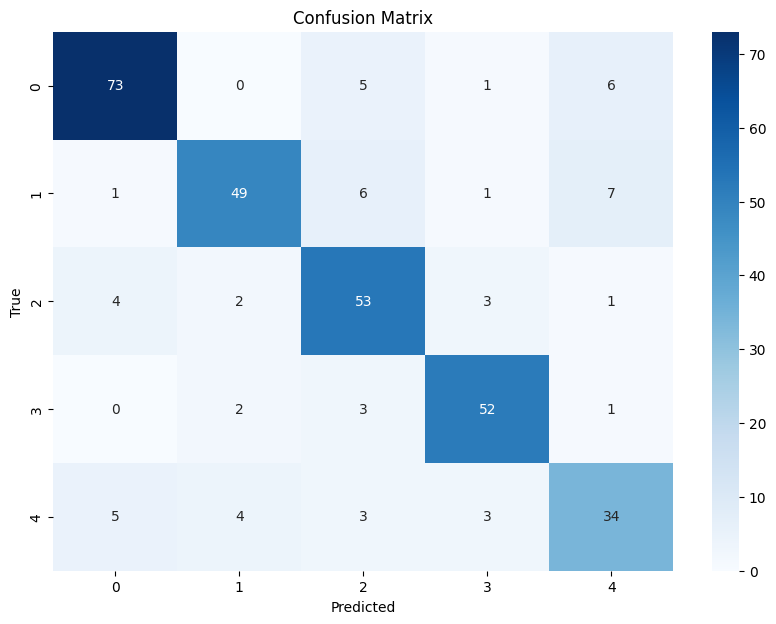

In [36]:
class_names = [0, 1, 2, 3, 4]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#  GRU

In [37]:
# Define model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300

model_GRU = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=False),
    Bidirectional(GRU(units=128,return_sequences=True)),
    Bidirectional(GRU(64)),
    Dense(units=512, activation='relu'),
    Dropout(rate=0.5),
    Dense(units=5, activation='softmax')
])

# Compile the model
model_GRU.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_GRU.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 4431, 300)         6408900   
                                                                 
 bidirectional_2 (Bidirecti  (None, 4431, 256)         330240    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               123648    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [38]:
history = model_GRU.fit(x=x_train_pad, y=y_train_cat, epochs=23,
                        validation_data=(x_val_pad, y_val_cat),
                        callbacks=[lr_scheduler])


Epoch 1/23
47/47 [==============================] - 33s 560ms/step - loss: 1.5781 - accuracy: 0.2728 - val_loss: 1.5255 - val_accuracy: 0.3041 - lr: 0.0010
Epoch 2/23
47/47 [==============================] - 25s 527ms/step - loss: 1.4854 - accuracy: 0.3522 - val_loss: 1.4530 - val_accuracy: 0.3574 - lr: 0.0010
Epoch 3/23
47/47 [==============================] - 25s 527ms/step - loss: 1.2368 - accuracy: 0.4940 - val_loss: 1.1468 - val_accuracy: 0.5486 - lr: 0.0010
Epoch 4/23
47/47 [==============================] - 25s 528ms/step - loss: 0.9448 - accuracy: 0.6324 - val_loss: 1.0204 - val_accuracy: 0.6207 - lr: 0.0010
Epoch 5/23
47/47 [==============================] - 25s 528ms/step - loss: 0.8524 - accuracy: 0.6962 - val_loss: 0.8695 - val_accuracy: 0.6897 - lr: 0.0010
Epoch 6/23
47/47 [==============================] - 25s 528ms/step - loss: 0.6695 - accuracy: 0.7648 - val_loss: 0.9418 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 7/23
47/47 [==============================] - 25s 527ms/st

In [39]:
# Predict the labels for the training and validation sets
y_train_pred = model_GRU.predict(x_train_pad)
y_test_pred = model_GRU.predict(x_test_pad)

# Convert the predictions and true labels to class labels (from one-hot encoding)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_train_true_classes = np.argmax(y_train_cat, axis=1)

y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test_cat, axis=1)

# Calculate the accuracy for both training and validation sets
train_accuracy = accuracy_score(y_train_true_classes, y_train_pred_classes) * 100
test_accuracy = accuracy_score(y_test_true_classes, y_test_pred_classes) * 100

# Print the accuracies in the desired format
print(f'Train Accuracy : {train_accuracy:.2f} %')
print(f'Test Accuracy  : {test_accuracy:.2f} %')

10/10 [==============================] - 2s 197ms/step
Train Accuracy : 98.39 %
Test Accuracy  : 82.76 %


In [40]:
# Create a figure with two horizontal subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=['Training and Validation Loss', 'Training and Validation Accuracy'], shared_yaxes=True)

# Loss plot
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['loss'])+1)), y=history.history['loss'], mode='lines', name='Training Loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_loss'])+1)), y=history.history['val_loss'], mode='lines', name='Validation Loss'), row=1, col=1)
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Loss', row=1, col=1)

# Accuracy plot
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['accuracy'])+1)), y=history.history['accuracy'], mode='lines', name='Training Accuracy'), row=1, col=2)
fig.add_trace(go.Scatter(x=list(range(1, len(history.history['val_accuracy'])+1)), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'), row=1, col=2)
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)

# Update layout and show the figure
fig.update_layout(height=600, width=1200, showlegend=True)
fig.show()

In [41]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)

print(classification_report(y_test_true_classes, y_test_pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90        85
           1       0.85      0.73      0.79        64
           2       0.85      0.89      0.87        63
           3       0.75      0.93      0.83        58
           4       0.74      0.63      0.68        49

    accuracy                           0.83       319
   macro avg       0.82      0.82      0.81       319
weighted avg       0.83      0.83      0.83       319



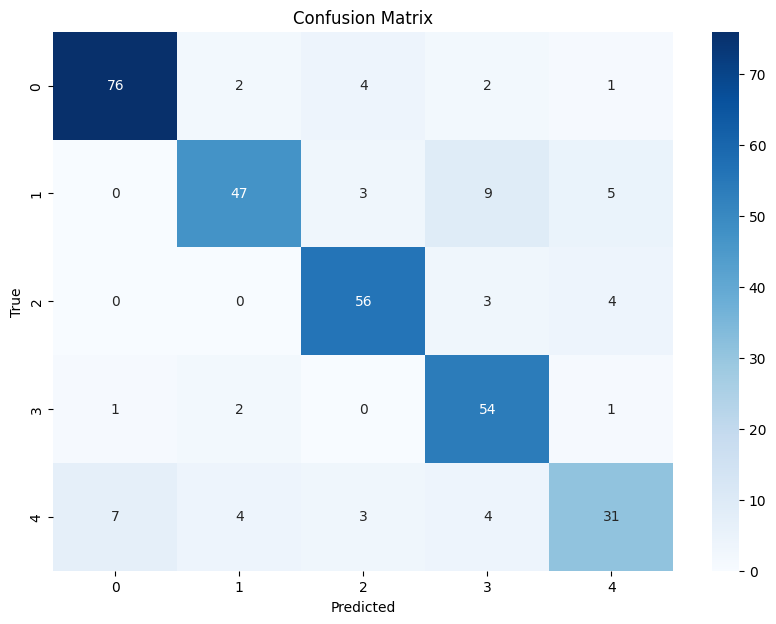

In [42]:
class_names = [0, 1, 2, 3, 4]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()